In [283]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import sys

from ConvVAE import ConvVAE

# nicer printing, optional
np.set_printoptions(precision=4, edgeitems=6, linewidth=120, suppress=True)

DATA_DIR = "record_breakout"
MODEL_DIR = "models_vae_breakout"
z_size = 128   # same as training

In [284]:
# pick a random trajectory file
filelist = [f for f in os.listdir(DATA_DIR) if f.endswith(".npz")]
chosen_file = random.choice(filelist)
print("Using file:", chosen_file)

data = np.load(os.path.join(DATA_DIR, chosen_file))
obs = data["obs"]              # shape (T,84,84,1), dtype uint8
print("obs shape:", obs.shape, "dtype:", obs.dtype, "min/max:", obs.min(), obs.max())

# normalize to [0,1] for the VAE
obs_f = obs.astype(np.float32) / 255.0

# pick one random frame and add batch axis
frame = random.choice(obs_f)           # (84,84,1)
frame = frame[None, ...]               # (1,84,84,1)
print("single frame shape:", frame.shape)


Using file: 1702401667.npz
obs shape: (163, 84, 84, 1) dtype: uint8 min/max: 0 147
single frame shape: (1, 84, 84, 1)


In [285]:
# CPU test: gpu_mode=False
vae = ConvVAE(
    z_size=z_size,
    batch_size=1,
    learning_rate=1e-4,
    kl_tolerance=0.5,
    is_training=False,
    gpu_mode=False,
)

# load the trained weights (.pt checkpoint)
ckpt_path = os.path.join(MODEL_DIR, "vae.pt")
vae.load_checkpoint(ckpt_path)
print("Loaded checkpoint:", ckpt_path)


Loading model from models_vae_breakout\vae.pt
Loaded checkpoint: models_vae_breakout\vae.pt


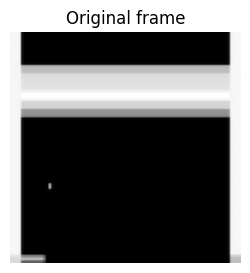

In [286]:
plt.figure(figsize=(3,3))
# squeeze batch and channel dimension for display
plt.imshow(frame[0, :, :, 0], cmap="gray")
plt.title("Original frame")
plt.axis("off")
plt.show()


In [287]:
# encode to latent z (sampled)
batch_z = vae.encode(frame)        # shape (1, z_size)
print("Sampled z vector (first 10 dims):", batch_z[0][:10])

# decode back to image
reconstruct = vae.decode(batch_z)  # shape (1,84,84,1) in [0,1]
print("reconstruct shape:", reconstruct.shape,
      "min/max:", reconstruct.min(), reconstruct.max())


Sampled z vector (first 10 dims): [-0.5629 -0.3403  1.7174 -0.9247  0.7709  1.7219 -0.1928  1.0945 -0.8595  0.0398]
reconstruct shape: (1, 84, 84, 1) min/max: 0.0 0.57688504


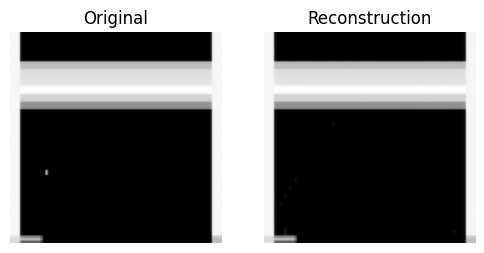

In [288]:
fig, axes = plt.subplots(1, 2, figsize=(6,3))

axes[0].imshow(frame[0, :, :, 0], cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(reconstruct[0, :, :, 0], cmap="gray")
axes[1].set_title("Reconstruction")
axes[1].axis("off")

plt.show()
